In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# en su linea de comandos ejecutar:
# pip install pandas
# pip install numpy

### Carga de datos y formación de matrices doble estocásticas de ejemplo!

In [3]:
def normalize_by_row(W):
    w_norm = np.zeros(W.shape)
    print(W.shape)
    for i in range(W.shape[0]):
        w_norm[i] = W[i] / W[i].sum()
    return w_norm

# adjacencia
W = np.array(pd.read_excel('./data/adjacency.xlsx', header=None))
W_doble_estocastica = np.array(pd.read_excel('./data/doble_estocastica.xlsx', header=None))
df_data = pd.read_excel('./data/testdata_dist.xlsx', header=None)
df_data.columns = ['Px','Py','Z']

I = np.identity(W.shape[0])
#W_tilt = np.array((I + W) / 2) # Recomendación del artículo, is not 
W_tilt = normalize_by_row(W) # it satisfies de condition of mixing matrix as stichastic

(10, 10)


In [4]:
W_doble_estocastica

array([[0. , 0.7, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.7, 0. , 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.3, 0.1, 0. , 0.1, 0. , 0. , 0.1, 0.4, 0. , 0. ],
       [0. , 0.1, 0.1, 0. , 0. , 0.1, 0.7, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0.6, 0. , 0. , 0.3, 0. ],
       [0. , 0. , 0. , 0.1, 0.6, 0. , 0. , 0. , 0.3, 0. ],
       [0. , 0. , 0.1, 0.7, 0. , 0. , 0. , 0. , 0.1, 0.1],
       [0. , 0. , 0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0.6],
       [0. , 0. , 0. , 0. , 0.3, 0.3, 0.1, 0. , 0. , 0.3],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.6, 0.3, 0. ]])

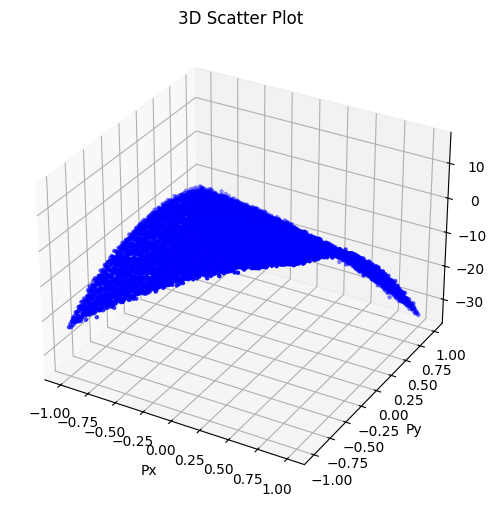

In [5]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_data['Px'], df_data['Py'], df_data['Z'], c='blue', marker='.')  # 'c' sets the color, 'marker' sets the marker style


# Set labels for the axes
ax.set_xlabel('Px')
ax.set_ylabel('Py')
ax.set_zlabel('Z')

# Set a title for the plot
ax.set_title('3D Scatter Plot')

plt.show()

Se ve que es un plano de la forma

$\hat{Z(\Theta, P_{i})} = a + b_{1}P_{x_{i}} + b_{2}P_{y_{i}} +  c_{33}P_{x_{i}}P_{y_{i}} + c_{11}P_{x_{i}}^{2} + c_{22}P_{y_{i}}^{2} $

Entonces se define la función objetivo local para cada nodo es como el error entre las dos predicciones

$ \epsilon = \frac{1}{n} \sum_{i=0}^{n} (\hat{Z_{i}}-Z_{i})^{2} = \frac{1}{n} \sum_{i=0}^{n} \delta_{i}$



### Ejecución del algoritmo EXTRA!

In [6]:

# Definición del método para la expresión de Z
def get_z(px_i, py_i, a, b_1, b_2, c_11, c_22, c_33):
    _z = a + b_1*px_i + b_2*py_i  + c_33*px_i*py_i + c_11*(px_i**2) + c_22*(py_i**2)
    return _z

# Implementación del algoritmo del gradiente descendente: Referencia, curso de Andrew NG de deep learning y https://www.youtube.com/watch?v=EfsjEOb596Q&t=836s
def repartir_datos_en_agentes(df, W):
    montante_por_agente = int(df_data.shape[0]/10)
    datos_por_agente = {}
    for i in range(W.shape[0]):
        datos_por_agente[i] = df[i*montante_por_agente: (i+1)*montante_por_agente]
    return datos_por_agente


def local_gradient_descent(df_agente, parametros_plano):

    dj_da, dj_db1, dj_db2, dj_dc11, dj_dc22, dj_dc33, J_cost = 0,0,0,0,0,0,0

    a = parametros_plano[0] 
    b1 = parametros_plano[1]
    b2 = parametros_plano[2]
    c11 = parametros_plano[3]
    c22 = parametros_plano[4]
    c33 = parametros_plano[5]
    
    # calcular el gradiente medio para los valores distribuidos al agente de este gradiente
    for P in df_agente[['Px', 'Py', 'Z']].values:
        px_i = P[0]
        py_i = P[1]
        Z = P[2]
        # delta calculus
        z_hat_ = get_z(px_i, py_i, a, b1, b2, c11, c22, c33)
        J_cost += np.square(z_hat_-Z)
        dj_dz = 2*(z_hat_-Z)
        dj_da += dj_dz*1
        dj_db1 += dj_dz*px_i
        dj_db2 += dj_dz*py_i
        dj_dc11 += dj_dz*(px_i**2)
        dj_dc22 += dj_dz*(py_i**2)
        dj_dc33 += dj_dz*(px_i*py_i)

    n = len(df_agente)
    dj_da = dj_da/n
    dj_db1 = dj_db1/n
    dj_db2 = dj_db2/n
    dj_dc11 = dj_dc22/n
    dj_dc22 = dj_dc22/n
    dj_dc33 = dj_dc33/n
    J_cost = J_cost/n

    return [dj_da,dj_db1, dj_db2, dj_dc11,dj_dc22, dj_dc33], J_cost
    
   


# Implementación del algoritmo del gradiente descendente: Referencia, curso de Andrew NG de deep learning y https://www.youtube.com/watch?v=EfsjEOb596Q&t=836s
def extra_algorithm(W_tilt,  df_data, num_iterations, alpha = 0.1):

    # distribuir los datos para cada agente
    datos_distr_por_agente = repartir_datos_en_agentes(df_data, W_tilt) # NECESITA CAMBIARSE aqui repartir los datos de forma ALEATORIA es importante para mantener la topologia del plano para todos los agentes que ven un subconjunto de datos cada uno
    x_nodos = {} 
    grad_x_nodos = {}
    costos_locales = {}
    for k in range(num_iterations):
        x_nodos[k] = {}
        grad_x_nodos[k] = {}
        costos_locales[k] = {}
        for i in range(W.shape[0]):
            if k == 0: # k=0 a cero es para inciar aleatoriamente los parametros del plano para cada nodo
                # init coef. aleatoriamente para cada agente en k = 0, que corresponden a los parametros del vector x
                s = np.random.uniform(-5,5,6) # genera 6 numeros aleatorios que son mayores que -5 y menores que 5 (los itervalos los define como quiera)
                a_i = s[0]
                b1_i = s[1]
                b2_i = s[2]
                c11_i = s[3]
                c22_i = s[4]
                c33_i = s[5]
                # indices de las listas: a_i = 0, b1_i = 1, b2_i = 2, c11_i =3, c22_i = 4, c33_i = 5
                x_nodos[k][i] = [a_i, b1_i, b2_i, c11_i, c22_i, c33_i]
                grad_x_nodos[k][i], costos_locales[k][i] = local_gradient_descent(datos_distr_por_agente[i], x_nodos[k][i])
                continue
            #### primer paso del EXTRA ####
            if k == 1:
                # primer termino del EXTRA en k=1
                primer_termino_k_1 = [0,0,0,0,0,0]
                for j in x_nodos[k-1].keys():
                    primer_termino_k_1[0] += x_nodos[k-1][j][0] * W_tilt[i][j]
                    primer_termino_k_1[1] += x_nodos[k-1][j][1] * W_tilt[i][j]
                    primer_termino_k_1[2] += x_nodos[k-1][j][2] * W_tilt[i][j]
                    primer_termino_k_1[3] += x_nodos[k-1][j][3] * W_tilt[i][j]
                    primer_termino_k_1[4] += x_nodos[k-1][j][4] * W_tilt[i][j]
                    primer_termino_k_1[5] += x_nodos[k-1][j][5] * W_tilt[i][j]
                # segundo termino del EXTRA en k=1
                segundo_termino_k_1 = np.multiply(alpha, grad_x_nodos[k-1][i]) # multiplica cada item del vector de gradientes
                # o se puede hacer así!
                # actualización de X: x_nodos de acuerdo a al formula del primer paso de EXTRA
                x_nodos[k][i] = [primer_termino_k_1[0] -segundo_termino_k_1[0], # -> a_i
                                primer_termino_k_1[1]-segundo_termino_k_1[1], # -> b1_i
                                primer_termino_k_1[2]-segundo_termino_k_1[2], # -> b2_i
                                primer_termino_k_1[3]-segundo_termino_k_1[3], # -> c11_i
                                primer_termino_k_1[4]-segundo_termino_k_1[4], # -> c22_i
                                primer_termino_k_1[5]-segundo_termino_k_1[5]] # -> c33_i
                # actualización de los gradientes
                grad_x_nodos[k][i], costos_locales[k][i] = local_gradient_descent(datos_distr_por_agente[i], x_nodos[k][i])
                continue

            #### demás pasos del extra EXTRA ####
            # Primer termino
            x_k_menos_1 = x_nodos[k-1][i]
            # segundo termino
            segundo_termino = [0,0,0,0,0,0]
            for j in x_nodos[k-1].keys():
                segundo_termino[0] += x_nodos[k-1][j][0] * W_tilt[i][j] # -> a_i
                segundo_termino[1] += x_nodos[k-1][j][1] * W_tilt[i][j] # -> b1_i
                segundo_termino[2] += x_nodos[k-1][j][2] * W_tilt[i][j] # -> b2_i
                segundo_termino[3] += x_nodos[k-1][j][3] * W_tilt[i][j] # -> c11_i
                segundo_termino[4] += x_nodos[k-1][j][4] * W_tilt[i][j] # -> c22_i
                segundo_termino[5] += x_nodos[k-1][j][5] * W_tilt[i][j] # -> c33_i
            # tercer termino
            tercer_termino = [0,0,0,0,0,0]
            for j in x_nodos[k-2].keys(): # DIEGO: REEMPLAZAR W POR W doble estocástica!
                tercer_termino[0] += x_nodos[k-2][j][0] * W_tilt[i][j]
                tercer_termino[1] += x_nodos[k-2][j][1] * W_tilt[i][j]
                tercer_termino[2] += x_nodos[k-2][j][2] * W_tilt[i][j]
                tercer_termino[3] += x_nodos[k-2][j][3] * W_tilt[i][j]
                tercer_termino[4] += x_nodos[k-2][j][4] * W_tilt[i][j]
                tercer_termino[5] += x_nodos[k-2][j][5] * W_tilt[i][j]
            # cuarto termino
            cuarto_termino = np.multiply(alpha, np.subtract(grad_x_nodos[k-1][i], grad_x_nodos[k-2][i]))
            # O se puede hacer así
            # actualización de X: x_nodos de acuerdo a al formula del primer paso de EXTRA
            x_nodos[k][i] = [x_k_menos_1[0]+segundo_termino[0]-tercer_termino[0]-cuarto_termino[0], # -> a_i
                                x_k_menos_1[1]+segundo_termino[1]-tercer_termino[1]-cuarto_termino[1], # -> b1_i
                                x_k_menos_1[2]+segundo_termino[2]-tercer_termino[2]-cuarto_termino[2], # -> b2_i
                                x_k_menos_1[3]+segundo_termino[3]-tercer_termino[3]-cuarto_termino[3], # -> c11_i
                                x_k_menos_1[4]+segundo_termino[4]-tercer_termino[4]-cuarto_termino[4], # -> c22_i
                                x_k_menos_1[5]+segundo_termino[5]-tercer_termino[5]-cuarto_termino[5]] # -> c33_i
            #actualización del gradiente
            grad_x_nodos[k][i], costos_locales[k][i] = local_gradient_descent(datos_distr_por_agente[i], x_nodos[k][i])
            #print(f"valores de x_nodos[{k}][{i}] {x_nodos[k][i]}")
        
    return x_nodos, grad_x_nodos, costos_locales, datos_distr_por_agente # donde el último punto de x_nodos, tiene la solución final de los coeficientes a_i, b1_i, b2_i, c11_i, c22_i, c33_i



In [30]:
# ejecución del algoritmo EXTRA!
x_nodos, grad_x_nodos, costos_locales, datos_distr_por_agente = extra_algorithm(W_doble_estocastica, df_data, 300, 0.05)
#coef_ = return_coeficientes_medios_de_agentes()

### 2. Graficando la regla del vector

Como todos los agentes tienden a converger a los mismos coeficientes del plano, la regla del los vectores (o distancia euclidiana) entre todos los agentes debe ser aproximadamente cero ($0$)

$  \frac{1}{J}\sum_{j=0}^{J} \sqrt{(X^{i}(k) - X^{j}(k))^{2}} \approx 0$ Para cada nodo $i$

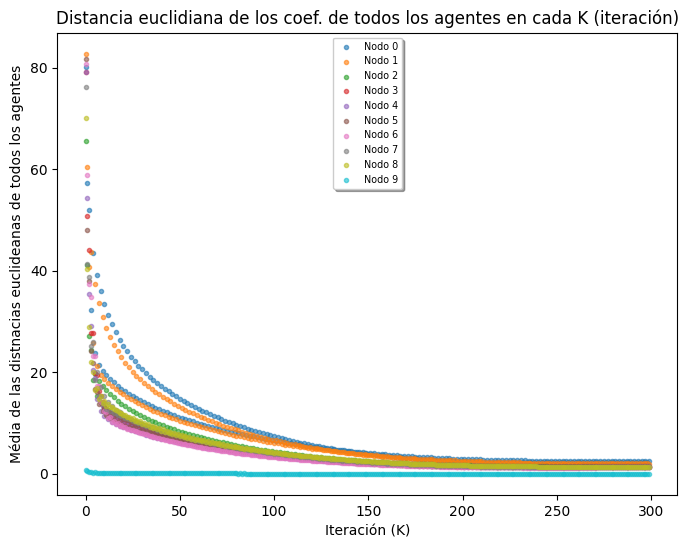

In [36]:
# x_nodos es la lista que contiene todos los coeficientes de los agentes en cada K, 
# por lo tanto usamos esos coeficientes para el caluclo total de las distancias euclideanas
node_l2_norm = {}
for k, nodes in x_nodos.items():
    node_l2_norm[k] = {}
    for i, coef_i in nodes.items():
        node_l2_norm[k][i] = 0.0
        for j, coef_j in nodes.items():
            node_l2_norm[k][i] += np.linalg.norm(np.array(coef_i) - np.array(coef_j))
    i_por_j = len(nodes.keys()) ** 2
    node_l2_norm[k][i] = node_l2_norm[k][i]/i_por_j


# Código de la gráfica
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
x = list(range(len(node_l2_norm.values())))

"""
y_0 = []
for k,node in  node_l2_norm.items():
    y_0.append(node[0])

# o en una sola linea de código (abajo!)
"""
y_0 = [node[0] for k, node in node_l2_norm.items()]
ax.scatter(x, y_0, marker='.', alpha = 0.6, label = 'Nodo 0')  # 'c' sets the color, 'marker' sets the marker style

y_1 = [node[1] for k, node in node_l2_norm.items()]
ax.scatter(x, y_1, marker='.', alpha = 0.6, label = 'Nodo 1')  # 'c' sets the color, 'marker' sets the marker style

y_2 = [node[2] for k, node in node_l2_norm.items()]
ax.scatter(x, y_2, marker='.', alpha = 0.6, label = 'Nodo 2')  # 'c' sets the color, 'marker' sets the marker style

y_3 = [node[3] for k, node in node_l2_norm.items()]
ax.scatter(x, y_3, marker='.', alpha = 0.6, label = 'Nodo 3')  # 'c' sets the color, 'marker' sets the marker style

y_4 = [node[4] for k, node in node_l2_norm.items()]
ax.scatter(x, y_4, marker='.', alpha = 0.6, label = 'Nodo 4')  # 'c' sets the color, 'marker' sets the marker style

y_5 = [node[5] for k, node in node_l2_norm.items()]
ax.scatter(x, y_5, marker='.', alpha = 0.6, label = 'Nodo 5')  # 'c' sets the color, 'marker' sets the marker style

y_6 = [node[6] for k, node in node_l2_norm.items()]
ax.scatter(x, y_6, marker='.', alpha = 0.6, label = 'Nodo 6')  # 'c' sets the color, 'marker' sets the marker style

y_7 = [node[7] for k, node in node_l2_norm.items()]
ax.scatter(x, y_7, marker='.', alpha = 0.6, label = 'Nodo 7')  # 'c' sets the color, 'marker' sets the marker style

y_8 = [node[8] for k, node in node_l2_norm.items()]
ax.scatter(x, y_8, marker='.', alpha = 0.6, label = 'Nodo 8')  # 'c' sets the color, 'marker' sets the marker style

y_9 = [node[9] for k, node in node_l2_norm.items()]
ax.scatter(x, y_9, marker='.', alpha = 0.6, label = 'Nodo 9')  # 'c' sets the color, 'marker' sets the marker style

# Set labels for the axes
ax.set_xlabel('Iteración (K)')
ax.set_ylabel('Média de las distnacias euclideanas de todos los agentes')
ax.legend(loc='upper center', shadow=True, fontsize='x-small')
# Set a title for the plot
ax.set_title('Distancia euclidiana de los coef. de todos los agentes en cada K (iteración)')
plt.show()


### 3. Gráfico de la función de costo global

Como visto en las diapositivas, el costo global se define como:

$\sum_{i=1}^{N} f_{i}(x) = \sum_{i=1}^{N} \frac{1}{M} \sum_{m=0}^{M} (\hat{Z_{m}(x, P_{m}}) - Z_{m})^{2}$

Donde $i$ es el índice para cada agente, $N$ el número de agentes, $M$ el número de registros (datos) que le corresponde a un agente y $m$ el registro específico dentro del conjunto de datos $M$

Entonces la función de costo global resulta en la sieguinte forma:

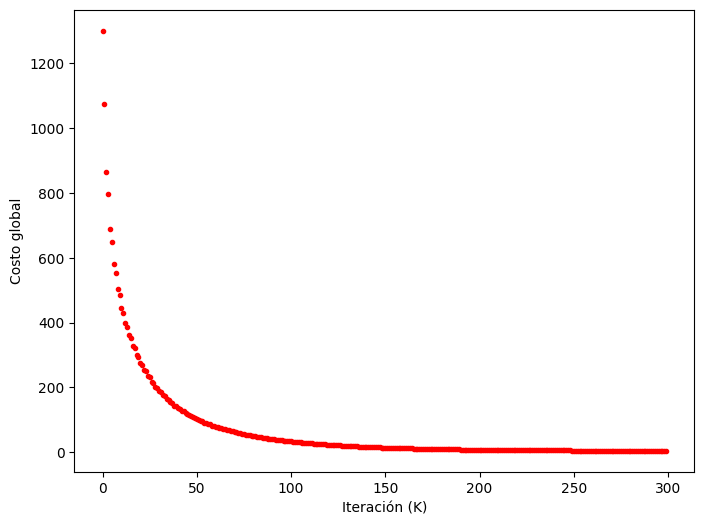

In [33]:
# en la variable "costos_locales" se almacenaron los costos de cada nodo i para cada iteración k
costos_agregados = {}
for k, nodes_cost in costos_locales.items():
    costos_agregados[k] = 0.0
    for i, costs in nodes_cost.items():
        costos_agregados[k] += costs

# Código de la gráfica
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
x = list(range(len(costos_agregados.values())))
y = list(costos_agregados.values())
ax.scatter(x, y, c='red', marker='.')  # 'c' sets the color, 'marker' sets the marker style
# Set labels for the axes
ax.set_xlabel('Iteración (K)')
ax.set_ylabel('Costo global')
plt.show()

### 4. Coeficientes optimos y gráficos del plano ajustado 

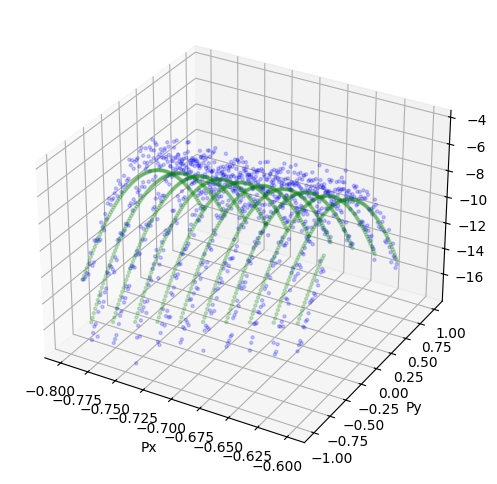

In [77]:
def plot_figs(planes):
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    for plane in planes:
        ax.scatter(plane['x'], plane['y'], plane['z'], c=plane['color'].values[0], marker='.', alpha = 0.2)
        
    # Set labels for the axes
    ax.set_xlabel('Px')
    ax.set_ylabel('Py')
    ax.set_zlabel('Z')
    
    plt.show()

# Se grafica como queda el ajuste de la porción de los datos que le corresponde a cada nodo 
node = 1 # esto para el nodo 1
itind = 199 # itind, indica la iteracón del algoritmo, si;endo que si son 200, la ú;tima iteración (o k) es 199
## plot random
plane_1 = pd.DataFrame()
plane_1['x'] = datos_distr_por_agente[node]['Px']
plane_1['y'] = datos_distr_por_agente[node]['Py']
plane_1['z'] = plane_1.apply(lambda row: get_z(row['x'], 
                                             row['y'], 
                                             x_nodos[itind][node][0], 
                                             x_nodos[itind][node][1], 
                                             x_nodos[itind][node][2], 
                                             x_nodos[itind][node][3], 
                                             x_nodos[itind][node][4], 
                                             x_nodos[itind][node][5]), axis = 1) 
plane_1['color'] = plane_1.apply(lambda row: 'green', axis = 1) 

plane_2 = pd.DataFrame()
plane_2['x'] = datos_distr_por_agente[node]['Px']
plane_2['y'] = datos_distr_por_agente[node]['Py']
plane_2['z'] = datos_distr_por_agente[node]['Z']
plane_2['color'] = plane_2.apply(lambda row: 'blue', axis = 1) 


plot_figs([plane_2, plane_1])

Graficando todo el plano ajustado!

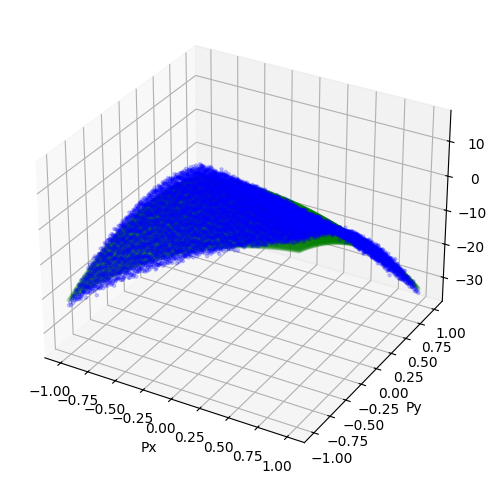

In [12]:
# Procesamiento de resultados
def return_coeficientes_medios_de_agentes(coef_nodos):
    average_coef = [0,0,0,0,0,0]
    for k,v in coef_nodos.items():
        average_coef[0] += v[0]
        average_coef[1] += v[1]
        average_coef[2] += v[2]
        average_coef[3] += v[3]
        average_coef[4] += v[4]
        average_coef[5] += v[5]
    n = len(coef_nodos.keys())
    average_coef[0] = average_coef[0]/n
    average_coef[1] = average_coef[1]/n
    average_coef[2] = average_coef[2]/n
    average_coef[3] = average_coef[3]/n
    average_coef[4] = average_coef[4]/n
    average_coef[5] = average_coef[5]/n
    return average_coef
    
final_coef = return_coeficientes_medios_de_agentes(x_nodos[199])

# plot

plane_1 = pd.DataFrame()
plane_1['x'] = df_data['Px']
plane_1['y'] = df_data['Py']
plane_1['y'] = df_data['Py']
plane_1['z'] = plane_1.apply(lambda row: get_z(row['x'], 
                                             row['y'], 
                                             final_coef[0], 
                                             final_coef[1], 
                                             final_coef[2], 
                                             final_coef[3], 
                                             final_coef[4], 
                                             final_coef[5]), axis = 1) 
plane_1['color'] = plane_1.apply(lambda row: 'green', axis = 1) 

plane_2 = pd.DataFrame()
plane_2['x'] = df_data['Px']
plane_2['y'] = df_data['Py']
plane_2['z'] = df_data['Z']
plane_2['color'] = plane_2.apply(lambda row: 'blue', axis = 1) 


plot_figs([plane_2, plane_1])

In [80]:
# coeficientes finales!
print('a:', final_coef[0])
print('b1:', final_coef[1])
print('b2:', final_coef[2])
print('c11:', final_coef[3])
print('c22:', final_coef[4])
print('c33:', final_coef[5])

a: -1.4374128875696746
b1: 4.437015647679628
b2: -9.999684026131922
c11: -6.377724746060872
c22: -6.810145913416501
c33: -12.180747070000981
